In [1]:
import subprocess
import os
from functools import lru_cache
import piff
from ngmix.prepsfmom import PGaussMom
from ngmix.medsreaders import NGMixMEDS
import numpy as np
import galsim
import fitsio
import wurlitzer
from contextlib import redirect_stdout, redirect_stderr

In [2]:
def _download_file(fname):
    os.makedirs("data", exist_ok=True)
    if not os.path.exists("./data/%s" % os.path.basename(fname)):
        cmd = """\
rsync \
-avP \
--password-file $DES_RSYNC_PASSFILE \
${DESREMOTE_RSYNC_USER}@${DESREMOTE_RSYNC}/%s \
./data/%s
    """ % (fname, os.path.basename(fname))
        s = subprocess.run(cmd, shell=True, capture_output=True)
        if s.returncode != 0:
            print(
                "download failed: %s" % (fname),
                flush=True,
            )
            raise RuntimeError(
                "download failed: %s %s" % (
                    s.stdout.decode("utf-8"), s.stderr.decode("utf-8"))
            )

    return "./data/%s" % os.path.basename(fname)


In [3]:
@lru_cache(maxsize=1024)
def _get_piff_path(se_filename):
    parts = se_filename.split("_")
    expnum = int(parts[0][1:])
    ccdnum = int(parts[2][1:])
    
    _query = """
    select
        d2.filename as redfile,
        fai.filename as filename,
        fai.path as path,
        m.band as band,
        m.expnum as expnum,
        m.ccdnum as ccdnum
    from
        desfile d1,
        desfile d2,
        proctag t,
        opm_was_derived_from wdf,
        miscfile m,
        file_archive_info fai
    where
        d2.filename = '%s'
        and d2.id = wdf.parent_desfile_id
        and wdf.child_desfile_id = d1.id
        and d1.filetype = 'piff_model'
        and d1.pfw_attempt_id = t.pfw_attempt_id
        and t.tag = 'Y6A2_PIFF_V2'
        and d1.filename = m.filename
        and d1.id = fai.desfile_id
        and fai.archive_name = 'desar2home'
    """ % (se_filename[:-3] if se_filename.endswith(".fz") else se_filename)
    
    piff_file = None
    
    import easyaccess as ea
    conn = ea.connect(section='desoper')
    curs = conn.cursor()
    curs.execute(_query)
    for row in curs:
        if row[4] == expnum and row[5] == ccdnum:
            piff_file = os.path.join(row[2], row[1])
    if piff_file is None:
        raise RuntimeError("could not find piff model for %s" % se_filename)
    
    return piff_file


@lru_cache(maxsize=200)
def _read_piff(fname):
    return piff.read(fname)

In [4]:
@lru_cache(maxsize=1024)
def _get_tile_path(tilename, band):
    _query = """select
        fai.path,
        concat(fai.filename, fai.compression) as filename,
        m.band,
        m.tilename
    from proctag t, miscfile m, file_archive_info fai
    where
        t.tag='Y6A2_COADD'
        and t.pfw_attempt_id=m.pfw_attempt_id
        and m.filetype='coadd_meds'
        and m.filename=fai.filename
        and m.tilename = '%s'
        and m.band = '%s'
    """ % (tilename, band)
    meds_file = None

    import easyaccess as ea
    conn = ea.connect(section='desoper')
    curs = conn.cursor()
    curs.execute(_query)
    for row in curs:
        if row[3] == tilename:
            meds_file = os.path.join(row[0], row[1])
    if meds_file is None:
        raise RuntimeError("could not find meds file for %s" % tilename)
    
    return meds_file


def _query_gold(tilename, band):
    os.makedirs("./gold_ids", exist_ok=True)
    gf = "./gold_ids/%s.fits" % tilename

    if not os.path.exists(gf):
        q = """\
    SELECT
        coadd_object_id
    FROM
        y6_gold_2_0
    WHERE
        flags_footprint > 0
        AND flags_gold = 0
        AND flags_foreground = 0
        AND ext_mash = 4
        AND tilename = '%s'; > gold_ids.fits
    """ % tilename
        with open("query.txt", "w") as fp:
            fp.write(q)
        subprocess.run("easyaccess --db dessci -l query.txt", shell=True, check=True)
        d = fitsio.read("gold_ids.fits")
        if band == "r":
            fitsio.write(gf, d, clobber=True)

        subprocess.run("rm -f gold_ids.fits", shell=True)
    else:
        d = fitsio.read(gf)

    return d["COADD_OBJECT_ID"]

In [5]:
def _draw_piff(x, y, pmod, color, use_piff_rend=False):
    PIFF_STAMP_SIZE = 25
    wcs = list(pmod.wcs.values())[0]
    chipnum = list(pmod.wcs.keys())[0]

    # compute the lower left corner of the stamp
    # we find the nearest pixel to the input (x, y)
    # and offset by half the stamp size in pixels
    # assumes the stamp size is odd
    # there is an assert for this below
    half = (PIFF_STAMP_SIZE - 1) / 2
    x_cen = np.floor(x+0.5)
    y_cen = np.floor(y+0.5)

    # make sure this is true so pixel index math is ok
    assert y_cen - half == int(y_cen - half)
    assert x_cen - half == int(x_cen - half)

    # compute bounds in Piff wcs coords
    xmin = int(x_cen - half)
    ymin = int(y_cen - half)

    dx = x - np.floor(x+0.5)
    dy = y - np.floor(y+0.5)    
    
    bounds = galsim.BoundsI(
        xmin, xmin+PIFF_STAMP_SIZE-1,
        ymin, ymin+PIFF_STAMP_SIZE-1,
    )
    image = galsim.ImageD(bounds, wcs=wcs)
    if use_piff_rend:
        return pmod.draw(
            x=x,
            y=y,
            chipnum=chipnum,
            GI_COLOR=color,
            stamp_size=25,
        )    
        
    else:
        return pmod.draw(
        x=x,
        y=y,
        chipnum=chipnum,
        image=image,
        GI_COLOR=color,
    )    

In [6]:
tname = "DES0131-3206"
band = "g"

gold_ids = _query_gold(tname, band)
meds_pth = _download_file(_get_tile_path(tname, band))

Connecting to DB ** desoper ** ...


In [7]:
try:
    mfile.close()
except Exception:
    pass
mfile = NGMixMEDS(meds_pth)

In [8]:
ii = mfile.get_image_info()

In [17]:
import tqdm

base_color = 0.61
color_min = 1.0
color_max = 1.7
rng = np.random.RandomState(seed=10)

dTmax = []
dTmin = []
for ind in tqdm.trange(1, len(ii), ncols=79):
    fname = os.path.basename(ii["image_path"][ind])[:-3]
    piff_file = _get_piff_path(fname)
    try:
        piff_file = _download_file(piff_file)
        pmod = _read_piff(piff_file)
    except Exception:
        os.system("rm -f %s" % piff_file)
        
    for _ in range(100):
        y = rng.uniform(low=100, high=3900)
        x = rng.uniform(low=100, high=1900)
        pmed = _draw_piff(x, y, pmod, base_color)
        ptrue = _draw_piff(x, y, pmod, color_max)
        Tmed = 2*pmed.FindAdaptiveMom().moments_sigma**2
        Ttrue = 2*ptrue.FindAdaptiveMom().moments_sigma**2
        dTmax.append(Tmed-Ttrue)

        ptrue = _draw_piff(x, y, pmod, color_min)
        Tmed = 2*pmed.FindAdaptiveMom().moments_sigma**2
        Ttrue = 2*ptrue.FindAdaptiveMom().moments_sigma**2
        dTmin.append(Tmed-Ttrue)

100%|████████████████████████████████████████| 166/166 [04:16<00:00,  1.54s/it]


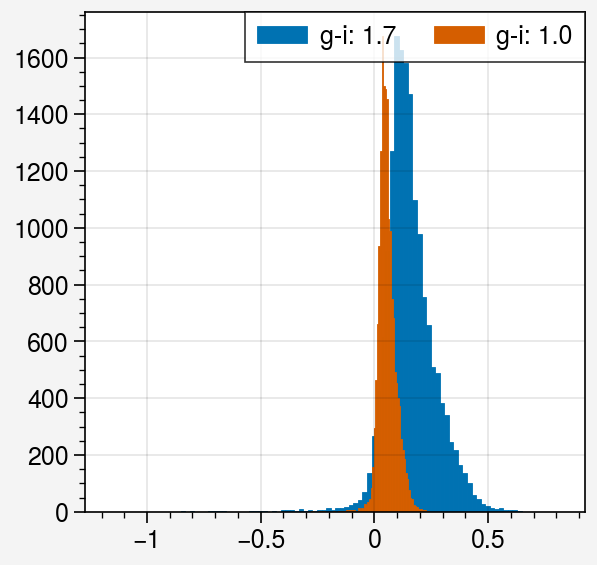

In [18]:
import proplot as pplt

fig, axs = pplt.subplots()

axs.hist(dTmax, bins=100, label="g-i: 1.7")
axs.hist(dTmin, bins=100, label="g-i: 1.0")
axs.legend()

In [19]:
np.median(dTmax)

0.14089027787879616